In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import requests
import tarfile
import zipfile
import scipy.io
from scipy.ndimage import gaussian_filter, convolve

def extract_zip(zip_path, extract_to):
    if not os.path.exists(extract_to):
        print("Extracting dataset...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print("Extraction complete.")
    else:
        print("Dataset already extracted.")

dataset_zip = "archive.zip"
dataset_folder = "BSDS500"
extract_zip(dataset_zip, dataset_folder)

Extracting dataset...
Extraction complete.


Epoch [1/100] -> Train Loss: 0.0241, Val Loss: 0.0235
Epoch [2/100] -> Train Loss: 0.0237, Val Loss: 0.0229
Epoch [3/100] -> Train Loss: 0.0229, Val Loss: 0.0219
Epoch [4/100] -> Train Loss: 0.0219, Val Loss: 0.0211
Epoch [5/100] -> Train Loss: 0.0211, Val Loss: 0.0207
Epoch [6/100] -> Train Loss: 0.0208, Val Loss: 0.0206
Epoch [7/100] -> Train Loss: 0.0207, Val Loss: 0.0203
Epoch [8/100] -> Train Loss: 0.0205, Val Loss: 0.0202
Epoch [9/100] -> Train Loss: 0.0204, Val Loss: 0.0202
Epoch [10/100] -> Train Loss: 0.0204, Val Loss: 0.0200
Epoch [11/100] -> Train Loss: 0.0203, Val Loss: 0.0203
Epoch [12/100] -> Train Loss: 0.0202, Val Loss: 0.0199
Epoch [13/100] -> Train Loss: 0.0201, Val Loss: 0.0199
Epoch [14/100] -> Train Loss: 0.0202, Val Loss: 0.0198
Epoch [15/100] -> Train Loss: 0.0200, Val Loss: 0.0199
Epoch [16/100] -> Train Loss: 0.0200, Val Loss: 0.0197
Epoch [17/100] -> Train Loss: 0.0199, Val Loss: 0.0197
Epoch [18/100] -> Train Loss: 0.0199, Val Loss: 0.0196
Epoch [19/100] -> T

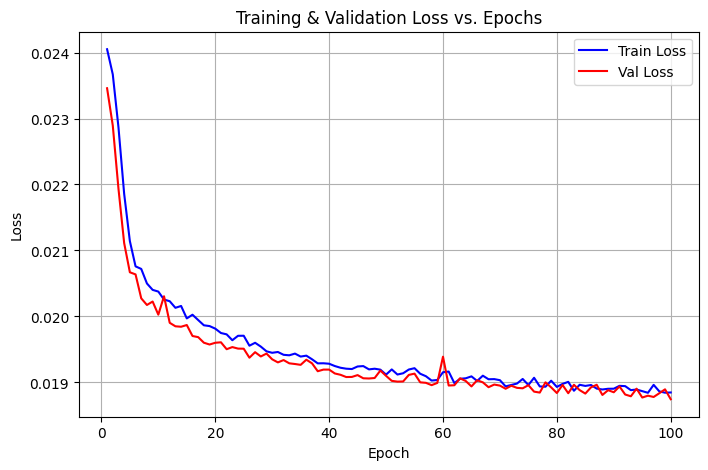

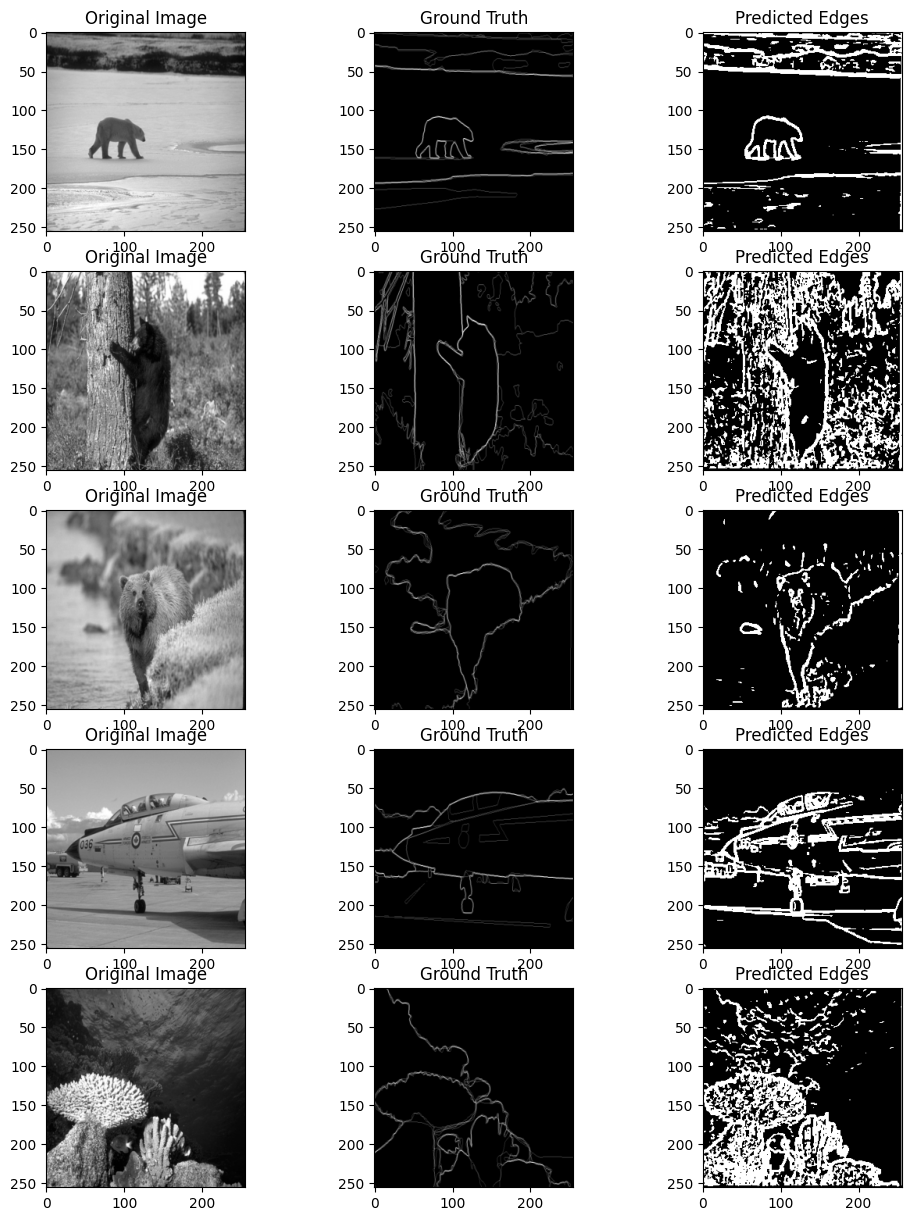

In [ ]:

device = torch.device("cpu")


# Load Dataset with Fixes
class BSDataset(Dataset):
    def __init__(self, image_dir, gt_dir, transform=None):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.gt_paths = sorted([os.path.join(gt_dir, f) for f in os.listdir(gt_dir) if f.endswith('.mat')])
        self.transform = transform

    def load_mat_image(self, mat_path):
        mat_data = scipy.io.loadmat(mat_path)
        if 'groundTruth' in mat_data:
            gt_list = mat_data['groundTruth'][0]
            gt_sum = sum(gt['Boundaries'][0, 0] for gt in gt_list)
            gt_avg = gt_sum / len(gt_list)
            return gt_avg
        raise ValueError("Invalid .mat file structure.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
      image = Image.open(self.image_paths[idx]).convert("L")  # Convert to grayscale
      label = self.load_mat_image(self.gt_paths[idx])

      resize = transforms.Resize((256, 256))
      image = resize(image)
      label = Image.fromarray((label * 255).astype(np.uint8))
      label = resize(label)

      if self.transform:
          image = self.transform(image)  # Apply transform to input image
          label = transforms.ToTensor()(label)  # Convert label to tensor without normalization

      return image, label

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize
])

train_dataset = BSDataset("BSDS500/images/train", "BSDS500/ground_truth/train", transform)
val_dataset = BSDataset("BSDS500/images/val", "BSDS500/ground_truth/val", transform)
test_dataset = BSDataset("BSDS500/images/test", "BSDS500/ground_truth/test", transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Define CNN Model
class EdgeDetectionCNN(nn.Module):
    def __init__(self):
        super(EdgeDetectionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.sigmoid(self.conv3(x))  # Sigmoid to normalize output
        return x

model = EdgeDetectionCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 3. Define Class-Balanced Loss (weighted)
def class_balanced_loss(pred, target):
    target = target.float().to(device)
    pred = pred.to(device)
    count_pos = torch.sum(target)  # Count positive pixels
    count_neg = target.numel() - count_pos  # Count negative pixels
    total = count_neg + count_pos + 1e-6  # Avoid division by zero

    weight_pos = count_neg / total
    weight_neg = 1 - weight_pos

    loss = -weight_pos * target * torch.log(pred + 1e-6) - weight_neg * (1 - target) * torch.log(1 - pred + 1e-6) # Ensure the function is defined by adding 1e-6
    return torch.mean(loss)

# Train Model and Track Loss
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = class_balanced_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation Loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = class_balanced_loss(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] -> Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plot Training & Validation Loss

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate Model on Test Set
model.eval()
fig, axs = plt.subplots(5, 3, figsize=(12, 15))

with torch.no_grad():
    for i, (image, gt) in enumerate(test_loader):
        image = image.to(device)
        output = model(image).cpu().squeeze().numpy()
        # Threshold to binarize output
        threshold = 0.5
        output_binary = (output > threshold).astype(np.uint8) * 255
        axs[i, 0].imshow(image.cpu().squeeze().numpy(), cmap="gray")
        axs[i, 0].set_title("Original Image")
        axs[i, 1].imshow(gt.cpu().squeeze().numpy(), cmap="gray")
        axs[i, 1].set_title("Ground Truth")
        axs[i, 2].imshow(output_binary, cmap="gray")
        axs[i, 2].set_title("Predicted Edges")
        if i == 4:
            break
plt.show()
